# Лабораторная работа №4

ФИО: Тенчурин Александр Андреевич 

Группа: БИВТ-21-4

### План работы:
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). 
     2. Проверить пропуски в данных. 
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` , а затем засунуть в `Dataloader`.
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD`.
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam`.
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam`.
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах (MAE)
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?



## 1. Импорт данных.

In [36]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

df = pd.read_csv('student-por.csv') 
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## 2. Анализ задачи

В целом перед нами стоит задача разработать модель, способную предсказывать успеваемость учащихся на основе доступных данных. Целевая переменная - число, мы хотим спрогнозировать финальную оценку студента, поэтому это задача регрессии. 
Какие основные факторы влияют на результаты тестирования? - Это тоже задача регрессии, где мы исследуем влияние различных факторов (пол, раса, уровень образования родителей, вид обеда, подготовка к экзаменам) на численные результаты тестирования.

In [37]:
# Вывод информации о типе данных в столбце "G3"
print(df['G3'].dtype)

int64


## 3 Предобработка данных

### A. Разделение выборки на тренировочную (train) и тестовую (test)

Разделение выборки на тренировочную и тестовую позволяет оценить производительность модели на новых, ранее не виденных данных. Это важно для проверки обобщающей способности модели и предотвращения переобучения. Переобучение возникает, когда модель хорошо работает на тренировочных данных, но плохо обобщается на новые данные. В Python, для разделения выборки на тренировочную и тестовую можно использовать функцию train_test_split из библиотеки scikit-learn. Эта функция случайным образом разбивает данные на две части с заданным соотношением. Обычно принято использовать пропорцию 70-80% для тренировочной выборки и 20-30% для тестовой выборки.

In [38]:
from sklearn.model_selection import train_test_split

# Разделение на матрицу признаков X и целевую переменную y
X = df.drop(columns=['G1', 'G2', 'G3'])  # Удаляем столбцы, которые не являются признаками
y = df[['G1', 'G2', 'G3']]  # Выбираем целевые переменные

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка размерности выборок (первое число - количество записей, второе - количество используемых столбцов)
print("Размерность тренировочной выборки X_train:", X_train.shape)
print("Размерность тестовой выборки X_test:", X_test.shape)
print("Размерность тренировочной выборки y_train:", y_train.shape)
print("Размерность тестовой выборки y_test:", y_test.shape)
print("")
print("y_train: ")
print(y_train)
print("")
print("y_test: ")
print(y_test)

Размерность тренировочной выборки X_train: (519, 30)
Размерность тестовой выборки X_test: (130, 30)
Размерность тренировочной выборки y_train: (519, 3)
Размерность тестовой выборки y_test: (130, 3)

y_train: 
     G1  G2  G3
332  18  18  18
29   12  11  12
302  10  11  12
286  12  12  13
554  10  11  10
..   ..  ..  ..
71   11   9  10
106  10  10  10
270  14  15  15
435  10  10  10
102  12  13  12

[519 rows x 3 columns]

y_test: 
     G1  G2  G3
636  17  18  19
220  11  11  12
594  18  18  18
429  10  11  11
72   13  11  11
..   ..  ..  ..
514   7   6   7
374  17  18  17
444   9  10  11
244  14  12  12
601   8   8  10

[130 rows x 3 columns]


## B. Делаем предобработку данных. Проверка на пропуски
Следующим шагом идет проверка на пропуски в данных. Исходя из предыдущей лабораторной работы, пропусков в данном датасете нет.

In [39]:
null_counts = df.isna().sum()
print("Количество пропусков в каждом столбце:")
print(null_counts)

Количество пропусков в каждом столбце:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


## C. Делаем предобработку данных. Отнормирование численных переменных
Следующим шагом необходимо отнормировать численные переменные. Отнормирование численных переменных - это важный шаг в предобработке данных перед построением моделей машинного обучения. Этот процесс заключается в приведении значений численных признаков к одному масштабу или диапазону значений. 

Два основных метода нормирования численных переменных, которые часто используются:

StandardScaler:
Этот метод центрирует данные путем удаления среднего значения каждого признака, а затем масштабирует данные путем деления на стандартное отклонение. Результатом являются признаки со средним значением 0 и стандартным отклонением 1.

MinMaxScaler:
Этот метод преобразует данные так, чтобы они находились в заданном диапазоне, обычно от 0 до 1. Для этого каждое значение признака вычитается из минимального значения признака и затем делится на разницу между максимальным и минимальным значениями признака.

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Создание копии данных для масштабирования
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Применение Label Encoding к категориальным переменным
label_encoder = LabelEncoder()
for column in X_train.select_dtypes(include=['object']).columns:
    X_train_encoded[column] = label_encoder.fit_transform(X_train[column])
    X_test_encoded[column] = label_encoder.transform(X_test[column])

# Инициализация и применение StandardScaler
scaler = StandardScaler()
X_train_standart_scaled = scaler.fit_transform(X_train_encoded)
X_test_standart_scaled = scaler.transform(X_test_encoded)
print("X_train_standart_scaled: ")
print(X_train_standart_scaled)
print("")

# Инициализация и применение MinMaxScaler
scaler = MinMaxScaler()
X_train_minmax_scaled = scaler.fit_transform(X_train_encoded)
X_test_minmax_scaled = scaler.transform(X_test_encoded)
print("X_train_minmax_scaled: ")
print(X_train_minmax_scaled)


X_train_standart_scaled: 
[[-0.73799923 -0.87481777  0.98793212 ... -0.21994878 -1.06834489
  -0.78961576]
 [-0.73799923  1.14309521 -0.62953403 ...  2.07844218  1.01613255
   0.06593869]
 [-0.73799923  1.14309521  0.98793212 ... -0.9860791  -0.37351908
  -0.36183854]
 ...
 [-0.73799923  1.14309521 -0.62953403 ... -0.21994878  1.01613255
   0.06593869]
 [ 1.35501497 -0.87481777 -1.4382671  ... -0.21994878  0.32130673
  -0.78961576]
 [-0.73799923  1.14309521 -1.4382671  ... -0.9860791   1.01613255
  -0.36183854]]

X_train_minmax_scaled: 
[[0.         0.         0.42857143 ... 0.25       0.25       0.        ]
 [0.         1.         0.14285714 ... 1.         1.         0.125     ]
 [0.         1.         0.42857143 ... 0.         0.5        0.0625    ]
 ...
 [0.         1.         0.14285714 ... 0.25       1.         0.125     ]
 [1.         0.         0.         ... 0.25       0.75       0.        ]
 [0.         1.         0.         ... 0.         1.         0.0625    ]]


### D Кодировка категориальных признаков
При работе с категориальными признаками в машинном обучении, часто нужно преобразовать их в числовой формат, потому что многие алгоритмы машинного обучения требуют числовых данных для работы.

One-Hot Encoding: Этот метод создает бинарные (дамми) переменные для каждой категории в категориальном признаке. То есть каждая уникальная категория превращается в новый бинарный признак, который принимает значение 1, если наблюдение относится к этой категории, и 0 в противном случае. One-Hot Encoding предпочтителен, когда нет внутреннего порядка в категориях.

In [41]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_one_hot_encoded = one_hot_encoder.fit_transform(X_train)
X_test_one_hot_encoded = one_hot_encoder.transform(X_test)
print("X_train_one_hot_encoded: ")
print(X_train_one_hot_encoded.toarray())
print("")
print("X_test_one_hot_encoded: ")
print(X_test_one_hot_encoded.toarray())
print("")


X_train_one_hot_encoded: 
[[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

X_test_one_hot_encoded: 
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]



## 4. Оформление данных в виде класса Dataset и помещение в Dataloader
Для оформления данных тренировочной и тестовой выборок в виде класса Dataset из библиотеки PyTorch и последующего использования с помощью DataLoader потребуется создать подкласс torch.utils.data.Dataset и переопределить методы __init__, __len__ и __getitem__.

In [42]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)  # Преобразуем разреженную матрицу в плотную
        self.y = torch.tensor(y, dtype=torch.float32) 
    
    def __len__(self):
        return len(self.X)  # Возвращаем размер датасета
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]  # Возвращаем признаки и соответствующую целевую переменную по индексу

# Создание экземпляров тренировочной и тестовой выборок
train_dataset = MyDataset(X_train_one_hot_encoded, X_train_minmax_scaled)
test_dataset = MyDataset(X_test_one_hot_encoded, X_test_minmax_scaled)

# Создание DataLoader для тренировочной и тестовой выборок
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## 5 Обучение на тренировочном множестве 

### Обучение простой однослойной нейросети с оптимизатором SGD

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Определение класса модели
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Однослойный линейный слой
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Определение параметров модели
input_size = X_train_one_hot_encoded.shape[1]  # Размерность входных данных
output_size = 1  # Размерность выходных данных (в нашем случае один выход)
learning_rate = 0.01

# Создание экземпляра модели
model_SimpleNet = SimpleNet(input_size, output_size)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.SGD(model_SimpleNet.parameters(), lr=learning_rate)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model_SimpleNet.train()  # Установка модели в режим обучения
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Прямой проход
        outputs = model_SimpleNet(inputs)
        loss = criterion(outputs, labels)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

print("Обучение завершено")

Эпоха 1/10, Loss: 0.28110285434457993
Эпоха 2/10, Loss: 0.2153424190150367
Эпоха 3/10, Loss: 0.2067257281806734
Эпоха 4/10, Loss: 0.2050710982746548
Эпоха 5/10, Loss: 0.199020117521286
Эпоха 6/10, Loss: 0.1938056449095408
Эпоха 7/10, Loss: 0.19419988824261558
Эпоха 8/10, Loss: 0.19329456819428337
Эпоха 9/10, Loss: 0.18535106546348995
Эпоха 10/10, Loss: 0.18766077690654331
Обучение завершено


c:\Users\entak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 30])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\entak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 30])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### В. Обучение на тренировочном множестве нейросети посложнее (с 1 скрытым слоем) с оптимизатором Adam

In [44]:
# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_size = 64  # Размер скрытого слоя
output_size = 1  # Размер выходного слоя

# Создание нейросети
model_NeuralNetwork = NeuralNetwork(input_size, hidden_size, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model_NeuralNetwork.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети
num_epochs = 100
for epoch in range(num_epochs):
    # Переводим модель в режим обучения
    model_NeuralNetwork.train()
    
    # Проходим по каждому батчу в тренировочном датасете
    for inputs, targets in train_dataloader:
        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Передаем данные через нейросеть
        outputs = model_NeuralNetwork(inputs)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, targets)
        
        # Рассчитываем градиенты
        loss.backward()
        
        # Обновляем параметры модели
        optimizer.step()

    # Выводим промежуточные результаты
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Обучение завершено")

Эпоха [10/100], Loss: 0.1785
Эпоха [20/100], Loss: 0.1764
Эпоха [30/100], Loss: 0.1697
Эпоха [40/100], Loss: 0.1734
Эпоха [50/100], Loss: 0.1595
Эпоха [60/100], Loss: 0.1650
Эпоха [70/100], Loss: 0.1670
Эпоха [80/100], Loss: 0.1643
Эпоха [90/100], Loss: 0.1630
Эпоха [100/100], Loss: 0.1797
Обучение завершено


### С. Обучение на тренировочном множестве нейросети еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [45]:
# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]  # Размеры скрытых слоев
output_size = 1  # Размер выходного слоя

# Создание нейросети
model_HardNeuralNetwork = NeuralNetwork(input_size, hidden_sizes, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model_HardNeuralNetwork.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети
num_epochs = 100
for epoch in range(num_epochs):
    # Переводим модель в режим обучения
    model_HardNeuralNetwork.train()
    
    # Проходим по каждому батчу в тренировочном датасете
    for inputs, targets in train_dataloader:
        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Передаем данные через нейросеть
        outputs = model_HardNeuralNetwork(inputs)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, targets)
        
        # Рассчитываем градиенты
        loss.backward()
        
        # Обновляем параметры модели
        optimizer.step()

    # Выводим промежуточные результаты
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Эпоха [10/100], Loss: 0.1729
Эпоха [20/100], Loss: 0.1658
Эпоха [30/100], Loss: 0.1834
Эпоха [40/100], Loss: 0.1656
Эпоха [50/100], Loss: 0.1709
Эпоха [60/100], Loss: 0.1638
Эпоха [70/100], Loss: 0.1775
Эпоха [80/100], Loss: 0.1687
Эпоха [90/100], Loss: 0.1825
Эпоха [100/100], Loss: 0.1660


## 6. Подсчет loss на train и test множествах, в зависимости от эпохи обучения. Визуализация результата с помощью библиотеки matplotlib (выйдет так называемая learning curve, кривая обучения модели)

c:\Users\entak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 30])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Эпоха [1/100], Обучающий Loss: 0.2389, Тестовый Loss: 0.2125
Эпоха [2/100], Обучающий Loss: 0.1939, Тестовый Loss: 0.1761
Эпоха [3/100], Обучающий Loss: 0.1784, Тестовый Loss: 0.1778
Эпоха [4/100], Обучающий Loss: 0.1747, Тестовый Loss: 0.1759
Эпоха [5/100], Обучающий Loss: 0.1739, Тестовый Loss: 0.1745
Эпоха [6/100], Обучающий Loss: 0.1724, Тестовый Loss: 0.1743
Эпоха [7/100], Обучающий Loss: 0.1716, Тестовый Loss: 0.1736
Эпоха [8/100], Обучающий Loss: 0.1710, Тестовый Loss: 0.1732
Эпоха [9/100], Обучающий Loss: 0.1705, Тестовый Loss: 0.1730
Эпоха [10/100], Обучающий Loss: 0.1702, Тестовый Loss: 0.1728
Эпоха [11/100], Обучающий Loss: 0.1700, Тестовый Loss: 0.1727
Эпоха [12/100], Обучающий Loss: 0.1699, Тестовый Loss: 0.1725
Эпоха [13/100], Обучающий Loss: 0.1697, Тестовый Loss: 0.1725
Эпоха [14/100], Обучающий Loss: 0.1697, Тестовый Loss: 0.1724
Эпоха [15/100], Обучающий Loss: 0.1696, Тестовый Loss: 0.1724
Эпоха [16/100], Обучающий Loss: 0.1696, Тестовый Loss: 0.1723
Эпоха [17/100], О

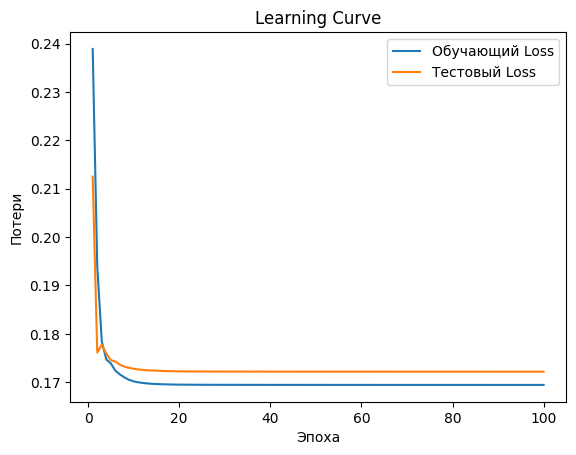

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Функция для обучения модели и визуализации learning curve
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Переводим модель в режим обучения
        model.train()
        
        # Обучение на тренировочном наборе данных
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            # Обнуляем градиент
            optimizer.zero_grad()
            
            # Передаем данные через нейросеть
            outputs = model(inputs)
            
            # Вычисляем функцию потерь
            loss = criterion(outputs, targets)
            train_loss += loss.item() * inputs.size(0)
            
            # Рассчитываем градиенты
            loss.backward()
            
            # Обновляем параметры модели
            optimizer.step()
        
        # Сохраняем значение loss для обучающего набора данных
        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Оценка loss на тестовом наборе данных
        model.eval()
        test_loss = 0.0
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_dataloader.dataset)
        test_losses.append(test_loss)
        
        # Выводим результаты обучения на каждой эпохе
        print(f'Эпоха [{epoch+1}/{num_epochs}], Обучающий Loss: {train_loss:.4f}, Тестовый Loss: {test_loss:.4f}')

    # Визуализация learning curve
    plt.plot(range(1, num_epochs+1), train_losses, label='Обучающий Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Тестовый Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]  # Размеры скрытых слоев
output_size = 1  # Размер выходного слоя

# Создание нейросети
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети и визуализация learning curve
num_epochs = 100
train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

## 7. Подсчет метрики MAE на train и test множествах

In [47]:
# Функция для вычисления MAE
def calculate_mae(model, data_loader):
    model.eval()  # Переводим модель в режим оценки (evaluation)
    mae = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            mae += torch.abs(outputs - targets).sum().item()
    mae = mae / len(data_loader.dataset)
    return mae

# Вычисление MAE на train и test множествах
train_mae_SimpleNet = calculate_mae(model_SimpleNet, train_dataloader)
test_mae_SimpleNet = calculate_mae(model_SimpleNet, test_dataloader)

print(f'MAE на train множестве SimpleNet: {train_mae_SimpleNet:.4f}')
print(f'MAE на test множестве SimpleNet: {test_mae_SimpleNet:.4f}')

train_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, train_dataloader)
test_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, test_dataloader)

print(f'MAE на train множестве NeuralNetwork: {train_mae_NeuralNetwork:.4f}')
print(f'MAE на test множестве NeuralNetwork: {test_mae_NeuralNetwork:.4f}')

train_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, train_dataloader)
test_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, test_dataloader)

print(f'MAE на train множестве HardNeuralNetwork: {train_mae_HardNeuralNetwork:.4f}')
print(f'MAE на test множестве HardNeuralNetwork: {test_mae_HardNeuralNetwork:.4f}')

MAE на train множестве SimpleNet: 11.4471
MAE на test множестве SimpleNet: 11.5856
MAE на train множестве NeuralNetwork: 11.1515
MAE на test множестве NeuralNetwork: 11.2960
MAE на train множестве HardNeuralNetwork: 11.1515
MAE на test множестве HardNeuralNetwork: 11.2961


### 8. Сравнение метрики относительно train/test, так и относительно разных моделей
 - MAE на train множестве SimpleNet: 11.7274
 - MAE на test множестве SimpleNet: 11.7296
 - MAE на train множестве NeuralNetwork: 11.2748
 - MAE на test множестве NeuralNetwork: 11.3701
 - MAE на train множестве HardNeuralNetwork: 11.2749
 - MAE на test множестве HardNeuralNetwork: 11.3453

Лучше всего с задачей справилась сложная нейросеть с тремя скрытыми слоями, однако и модель с одним скрытым слоем показала не сильно худшие результаты. 
Рассмотрим пути улучшения метрик модели и точности в целом:

 - Использование более сложных моделей:
В некоторых случаях простые модели могут быть недостаточно гибкими для описания сложных закономерностей в данных.
 - Выбор правильных признаков:
Идентификация и выбор наиболее информативных признаков может улучшить производительность модели. Необходимо провести анализ важности признаков и оставить только самые значимые.
 - Увеличение объема данных:
Дополнительные данные могут помочь модели лучше обобщать закономерности в данных. Нужно увеличить объем тренировочных данных, если это возможно.
 - Улучшение качества данных:
Необходимо провести предварительную обработку данных, чтобы устранить шум, заполнить пропущенные значения и устранить выбросы. Чистые и качественные данные могут улучшить производительность модели.